In [51]:
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

In [22]:
#Data Import, ref data from https://www.kaggle.com/areeves87/rscience-popular-comment-removal
file1 = "/Users/robjohns/Data/Metis/RedditComments/reddit_200k_train.csv"
file2 = "/Users/robjohns/Data/Metis/RedditComments/reddit_200k_test.csv"

train = pd.read_csv(file1,encoding='latin-1')
test = pd.read_csv(file2,encoding='latin-1')

In [21]:
train.head()

,Unnamed: 0,body,score.x,parent_id.x,id,created_utc.x,retrieved_on,REMOVED
0,1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,2,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


In [27]:
# I want to only treat the text for now, i can join back onto descriptors later if i desire
train_text= train.drop(['Unnamed: 0','score.x','parent_id.x','id','created_utc.x','retrieved_on','REMOVED'],axis=1)
test_text= test.drop(['Unnamed: 0','score.x','parent_id.x','id','created_utc.x','retrieved_on','REMOVED'],axis=1)

In [92]:
test_text.head()

,body
0,"Hi Larpo_Nadar, your submission has been remov..."
1,"So out of every 10,000 children with autism wh..."
2,"When I was pregnant, I was warned against eati..."
3,Imagine if this find was the bug that eradicat...
4,Is it a myth that the math says it would take ...


In [49]:
len(train_text),len(test_text)

(167529, 55843)

In [41]:
lens = train_text.body.str.len()

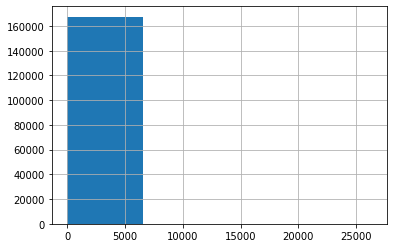

In [42]:
lens.hist(bins=4)

In [86]:
n = train_text.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=None,
               min_df=50, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words='english' )
trn_term_doc = vec.fit_transform(train_text['body'])
test_term_doc = vec.transform(test_text['body'])

In [87]:
trn_term_doc

<167529x9061 sparse matrix of type '<class 'numpy.float64'>'
	with 2746916 stored elements in Compressed Sparse Row format>

In [50]:
test_term_doc

<55843x89623 sparse matrix of type '<class 'numpy.float64'>'
	with 2760363 stored elements in Compressed Sparse Row format>

In [54]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [79]:
topics=10
indexer=[]
for _ in range(0,topics):
    indexer.append(f'comp{_}')

In [88]:
nmf_model = NMF(topics)
train_topic = nmf_model.fit_transform(trn_term_doc)

In [89]:
train_topic

array([[1.03782054e-02, 0.00000000e+00, 2.64495253e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.97503003e-03, 1.19598699e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.01959087e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.10553126e-03, 0.00000000e+00, 0.00000000e+00, ...,
        5.17061487e-04, 2.28125062e-02, 0.00000000e+00],
       [9.72745838e-03, 0.00000000e+00, 1.71053961e-04, ...,
        1.56404034e-03, 0.00000000e+00, 0.00000000e+00],
       [6.27797395e-03, 0.00000000e+00, 4.61899261e-04, ...,
        2.54970082e-03, 0.00000000e+00, 3.20281908e-04]])

In [90]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = indexer,
             columns = vec.get_feature_names())
topic_word

,00,000,000 000,000 people,000 year,000 years,0001f602,0001f914,001,01,...,youtube com,yr,yrs,yup,zealand,zero,zika,zinc,zone,zones
comp0,0.020,0.168,0.010,0.002,0.013,0.073,0.008,0.005,0.009,0.003,...,0.000,0.012,0.010,0.018,0.008,0.065,0.015,0.008,0.015,0.013
comp1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
comp2,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.003,0.000,0.000,...,0.000,0.000,0.001,0.000,0.000,0.006,0.002,0.000,0.002,0.000
comp3,0.006,0.036,0.000,0.004,0.001,0.003,0.000,0.000,0.017,0.061,...,0.025,0.000,0.000,0.000,0.003,0.006,0.005,0.006,0.005,0.006
comp4,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.000,0.001,0.000,0.003,0.001,0.003,0.000,0.000,0.005,0.001
comp5,0.000,0.000,0.001,0.000,0.000,0.000,0.004,0.000,0.000,0.004,...,0.000,0.000,0.000,0.004,0.001,0.012,0.000,0.000,0.000,0.000
comp6,0.000,0.012,0.003,0.032,0.000,0.000,0.000,0.007,0.000,0.000,...,0.000,0.000,0.000,0.001,0.000,0.006,0.000,0.000,0.000,0.000
comp7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,...,0.000,0.000,0.001,0.000,0.000,0.008,0.004,0.002,0.003,0.000
comp8,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.002,0.000,0.000,...,0.000,0.000,0.000,0.001,0.000,0.002,0.000,0.001,0.006,0.001
comp9,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000


In [91]:
display_topics(nmf_model, vec.get_feature_names(), 10)


Topic  0
time, years, good, ve, think, really, life, way, make, work

Topic  1
message, reddit, reddit com, www reddit, www, com, amp, mods, feel, following

Topic  2
like, sounds, sounds like, feel like, feel, looks, looks like, just like, look like, look

Topic  3
com, https, www, http, https www, study, nature, link, org, article

Topic  4
just, just like, maybe, want, people just, just want, eat, just need, say, just don

Topic  5
science, climate, political, sub, change, politics, climate change, isn, social, article

Topic  6
people, think, people don, likely, believe, people think, people just, want, lot, poor

Topic  7
does, mean, does mean, correlation, causation, doesn, correlation does, brain, does work, make

Topic  8
don, know, want, don know, think, don want, need, don think, people don, understand

Topic  9
removed, comments, comments removed, comment, deleted, thread, comment removed, comments deleted, happened, posts


In [ ]:
H = pd.DataFrame(doc_topic.round(5),
             index = ex_label,
             columns = ["component_1","component_2" ])
H